<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/logo_mt_0_0.png" WIDTH=280 HEIGHT=280>
</div>
<div id="subject">
<CENTER>
</br>
    
</CENTER>
<font size="5"></br> Copernicus Master on Digital Earth</font></br></div>
</CENTER>
<CENTER>
<font size="3"></br>September 23rd 2020</font></br></div>
</CENTER>
<CENTER>
<span style="color:blue">lucas.drumetz@imt-atlantique.fr</span>
</CENTER>

</div>

# Lab Session: Introduction to spectral unmixing

The goal of this lab is to get familiar with the unmixing of hyperspectral images and the techniques to solve this problem. We will implement a simple unmixing chain on an ideal simulated case first, and then on a real hyperspectral image.

# Part I: Simulated data

In this section, we will generate some simulated hyperspectral data by drawing abundances from a uniform distribution on the simplex, then implement an endmember extraction algorithm, and finally estimate abundances.

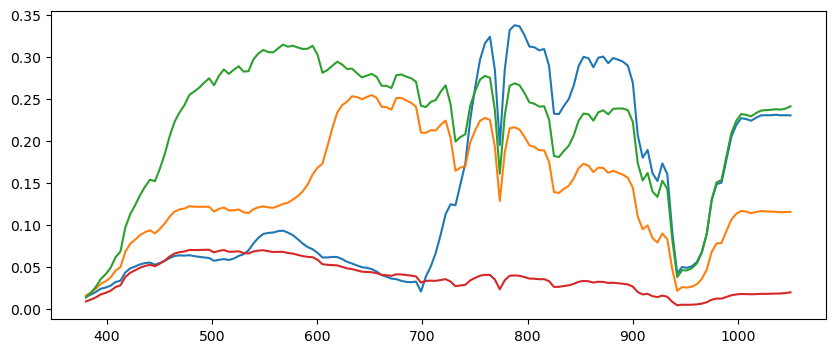

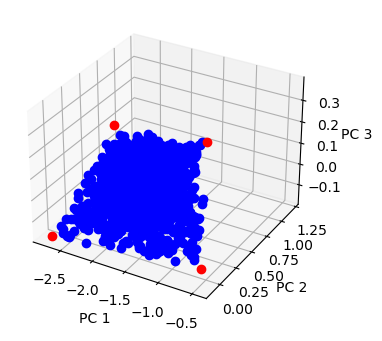

In [4]:
import numpy as np
import scipy.stats
import scipy.io as sio
import matplotlib.pyplot as plt

from pca_viz import pca_viz

## this code snippet generates 1000 points following a uniform distribution on the unit simplex with 3 vertices

alpha = [1,1,1,1]
A_synth_true = scipy.stats.dirichlet.rvs(alpha, size=1000).T

# this part loads some pure spectra taken from real data (vegetation/metallic sheets/asphalt/concrete)

endmembers = sio.loadmat("endmembers_houston.mat")
L = np.shape(endmembers['S0'])[0]
wavelengths = np.linspace(380,1050,L) #
S = endmembers['S0'][:,0:4]

plt.figure()
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(wavelengths, S)

synth_data = np.dot(S,A_synth_true) # X = SA

plt.rcParams["figure.figsize"] = (10,4)
pca_viz(synth_data,S) # this function is used to represent the data in a 3D space 
#(even though they actually live in an L-dimensional space)



In [5]:
#Number of bands
print(endmembers['S0'].shape)
#M
M=endmembers['S0'].shape[0]
print(M)
#L
print(L)
#a
print(A_synth_true.shape)

(144, 4)
144
144
(4, 1000)


How many spectral bands are there? Can you recognize some of the materials by their spectra? Implement the Successive Projection Algorithm (SPA) as seen during the lecture. Apply it on the synthetic dataset. Check the quality of the extracted endmembers. Are they exactly the same as the original endmembers? Why? Try with 4 endmembers.

**Answer**

4 spectral bands are there. I can recognize blue line as vegetation through its spectra. SPA is implemented below: 

[856, 612, 786, 704]


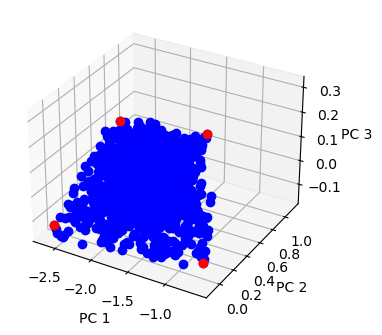

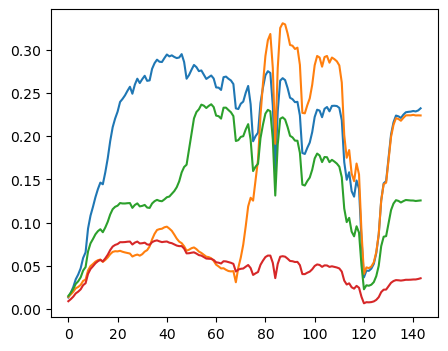

In [7]:
# useful functions : np.linalg.norm, np.dot, np.outer, np.argmax, np.apply_along_axis

P = 4 # number of endmembers

def SPA(data,P):
    data_to_project = data # initialize projected data
    endmember_coordinates = [] # initialize list of endmember indices
    # TO DO
    # .....
    R=data
    r=P
    k=1
    #I= np.eye(data.shape)
    while k<=r:
        norms= np.linalg.norm(R, axis=0)
        kStar= np.argmax(norms)
        #[:,k]kStar = np.argmax( np.linalg.norm((R[:,k])))
        
        uj = R[:, kStar]/ np.linalg.norm(R[:,kStar])
        
        R = R - np.dot(np.outer(uj,uj),R)
    
        endmember_coordinates.append(kStar)
        
        k=k+1
    
    endmembers=data[:,endmember_coordinates]
    
    return(endmembers,endmember_coordinates)
        
endmembers_synth,endmember_coordinates_synth = SPA(synth_data,P)

print(endmember_coordinates_synth)

# visualize the results

# %matplotlib notebook 
pca_viz(synth_data,endmembers_synth)

plt.figure()
plt.rcParams["figure.figsize"] = (5,4)
plt.plot(endmembers_synth)


#np.unravel_index  it is for converting it into 2D coordinates so that you have it on top of your image

In [26]:
endmembers['S0'].shape

(144, 4)

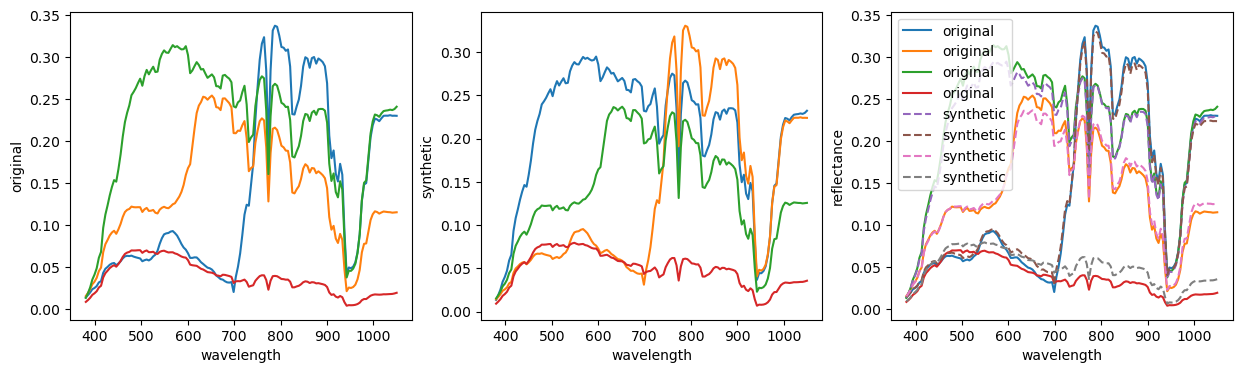

In [47]:
plt.figure()
plt.subplot(131)
plt.rcParams["figure.figsize"] = (15,4)
plt.plot(wavelengths,endmembers['S0'])
plt.ylabel('original')
plt.xlabel('wavelength')

plt.subplot(132)
plt.rcParams["figure.figsize"] = (15,4)
plt.plot(wavelengths,endmembers_synth)
plt.ylabel('synthetic')
plt.xlabel('wavelength')

plt.subplot(133)
plt.rcParams["figure.figsize"] = (15,4)
plt.plot(wavelengths,endmembers['S0'], label='original')
plt.plot(wavelengths,endmembers_synth,  linestyle='--', label='synthetic')
plt.ylabel('reflectance')
plt.xlabel('wavelength')
plt.legend()
plt.show()

- The synthetic and original endmembers are not exactly the same. There are some differences between the two.

In [48]:
# compute the abundances using the FCLSU algorithm (constrained least squares) and compare with the real values.

from FCLSU import FCLSU

A_synth = FCLSU(synth_data,endmembers_synth)



iteration  0  of  1000 , rel_phi = 0.5216715781940582
iteration  1  of  1000 , rel_phi = 0.3778298302132716
iteration  2  of  1000 , rel_phi = 0.8714720837848867
iteration  3  of  1000 , rel_phi = 0.487297457235786
iteration  4  of  1000 , rel_phi = 0.5651573564610696
iteration  5  of  1000 , rel_phi = 0.3257544819223775
iteration  6  of  1000 , rel_phi = 0.25855577828352716
iteration  7  of  1000 , rel_phi = 0.20010084106072384
iteration  8  of  1000 , rel_phi = 0.156646203252382
iteration  9  of  1000 , rel_phi = 0.13589593977032544
iteration  10  of  1000 , rel_phi = 0.12995473356239845
iteration  11  of  1000 , rel_phi = 0.10186287447873033
iteration  12  of  1000 , rel_phi = 0.1058085976982774
iteration  13  of  1000 , rel_phi = 0.08285315197951934
iteration  14  of  1000 , rel_phi = 0.08880233861056452
iteration  15  of  1000 , rel_phi = 0.07121318360390635
iteration  16  of  1000 , rel_phi = 0.07663083187860786
iteration  17  of  1000 , rel_phi = 0.060320216393235725
iteration  

Compare for a few pixels the estimated abundances with the true ones. Are they easily comparable? Why? How can we fix this?

Comparing first pixel of first band:  0.3715137500146124 0.1913642213106206
Difference between first pixel of real and synthetic abundance:  0.18014952870399178


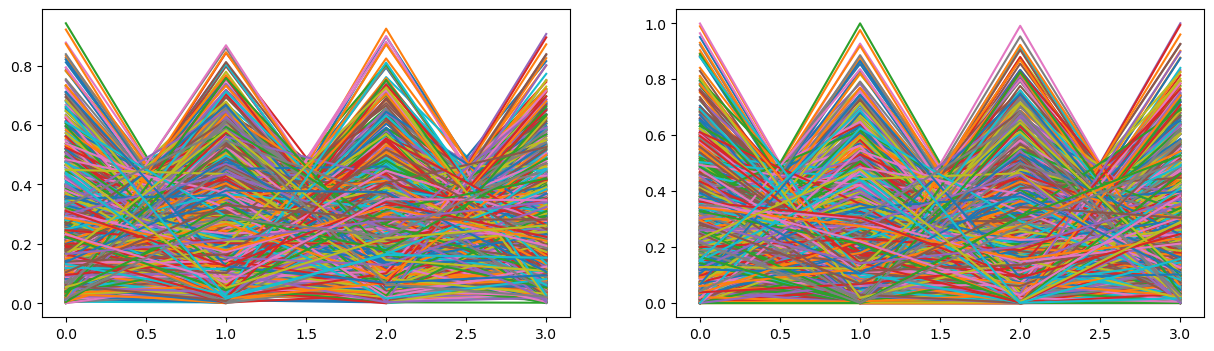

In [50]:
#Comparison
print("Comparing first pixel of first band: ", A_synth[0][0], A_synth_true[0][0] )
print("Difference between first pixel of real and synthetic abundance: ", A_synth[0][0]-A_synth_true[0][0] )


plt.figure
plt.subplot(121)
plt.plot(A_synth_true)

plt.subplot(122)
plt.plot(A_synth)
plt.show()

In [17]:
A_synth_true.shape

(4, 1000)

# Part II: Real Data

In this part, we are going to unmix a real image acquired by the airborne sensor AVIRIS over Calaveras Reservoir, California, USA. Don't hesitate to use Google maps to access a higher spatial resolution image over this scene:

https://www.google.fr/maps/place/Calaveras+Reservoir/@37.4777265,-121.8213273,4840m/data=!3m2!1e3!4b1!4m5!3m4!1s0x808fd026ab19d673:0x21f48327a3b3c623!8m2!3d37.4734195!4d-121.8192506

(199, 199, 192)
1.0
0.0


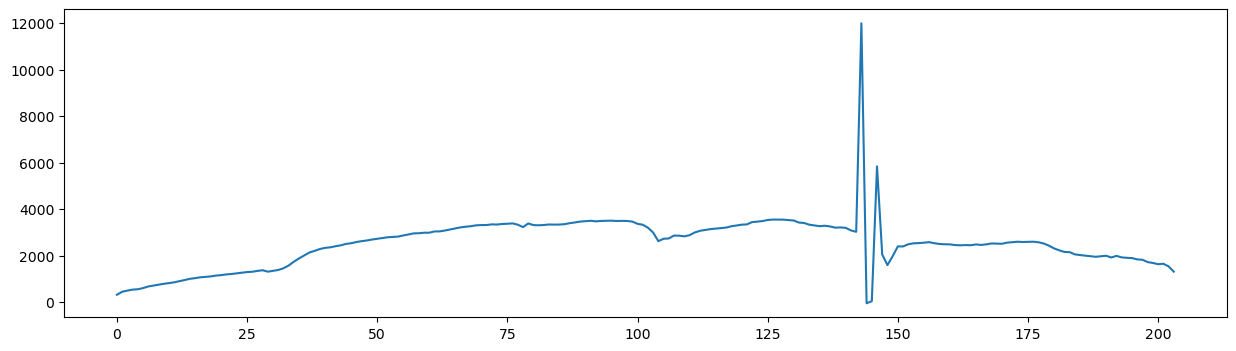

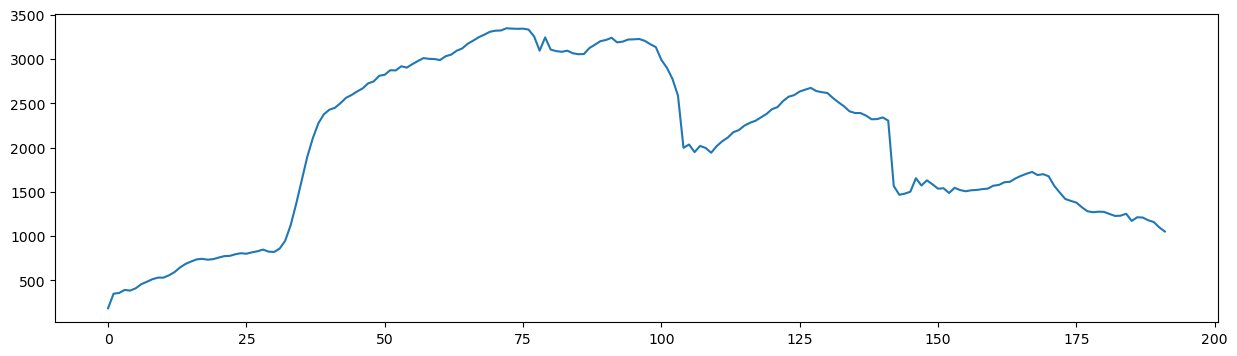

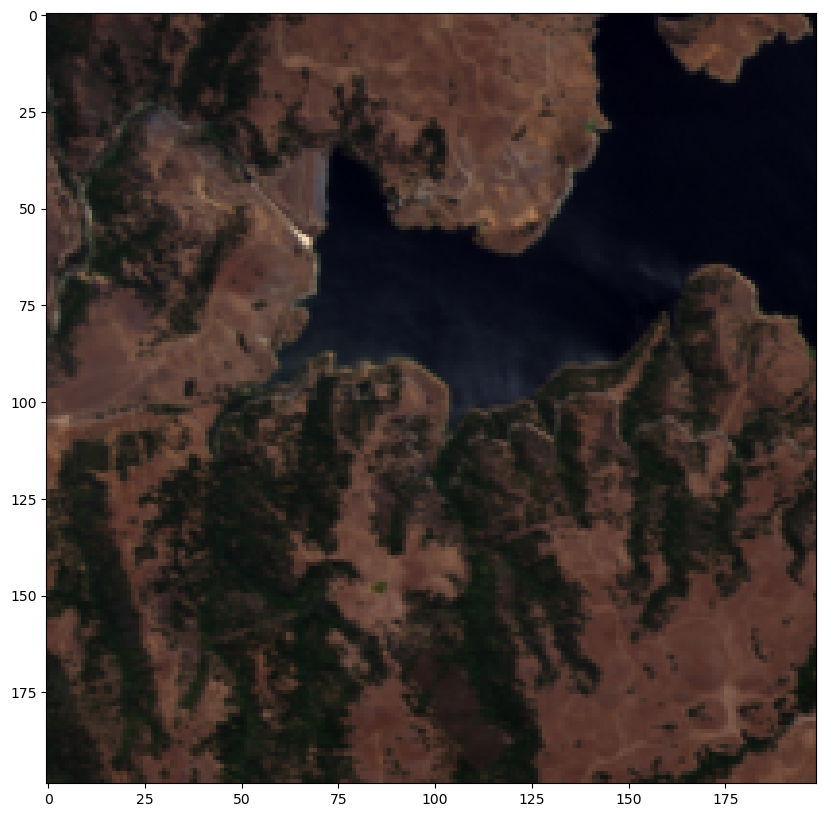

In [51]:
data = sio.loadmat("moffett1.mat")
im = data['im'].astype("double")
imrgb = data['imrgb']

plt.figure()
plt.plot(im[50,50,:]) # plot one pixel

im = np.delete(im,slice(200,224),axis =2) # delete noisy or corrupted bands
im = np.delete(im,slice(142,150),axis =2)
plt.figure()
plt.plot(im[35,24,:]) # plot one pixel after this

im = im[1:200,1:200,:] # select crop on which we will work

im = (im - np.amin(im))/(np.amax(im)-np.amin(im)) # rescale image

print(im.shape)
print(np.amax(im))
print(np.amin(im))


plt.figure(figsize=(20,10))
plt.imshow(imrgb[1:200,1:200,:])

[m,n,L] = im.shape
rgb_small =imrgb[1:200,1:200,:]


First, reshape the hyperspectral image as a $L\times N$ matrix, using the reshape function from numpy

In [53]:
# TO DO
print(im.shape)
#im.reshape(192, 198)

im_reshaped=im.reshape(199*199,192).T
print(im_reshaped.shape)

(199, 199, 192)
(192, 39601)


Use the SPA algorithm that you coded above to extract endmembers from the data. Use 4 endmembers at first. Represents the extracted pixels on the rgb image and try to visually identify them (you can use google maps as well). The "pca_viz" function provided represents the dataset and the extracted endmembers on a 3D space in the "best" way possible. 

In [54]:
print(S.shape)
print(endmembers['S0'].shape)

(144, 4)
(144, 4)


iteration  0  of  1000 , rel_phi = 0.7526802850483141
iteration  1  of  1000 , rel_phi = 0.1600990634406164
iteration  2  of  1000 , rel_phi = 0.13841627471025536
iteration  3  of  1000 , rel_phi = 0.09639986104646149
iteration  4  of  1000 , rel_phi = 0.04768392391769391
iteration  5  of  1000 , rel_phi = 0.008066628075880034
iteration  6  of  1000 , rel_phi = 0.007596746750993896
iteration  7  of  1000 , rel_phi = 0.00724165737085212
iteration  8  of  1000 , rel_phi = 0.013935245628021418
iteration  9  of  1000 , rel_phi = 0.014997947846230984
iteration  10  of  1000 , rel_phi = 0.017978632583338868
iteration  11  of  1000 , rel_phi = 0.00784117022361342
iteration  12  of  1000 , rel_phi = 0.006384804235636864
iteration  13  of  1000 , rel_phi = 0.003994840057259422
iteration  14  of  1000 , rel_phi = 0.009865264992796467
iteration  15  of  1000 , rel_phi = 0.009843688180903549
iteration  16  of  1000 , rel_phi = 0.011361033993849698
iteration  17  of  1000 , rel_phi = 0.008311407666

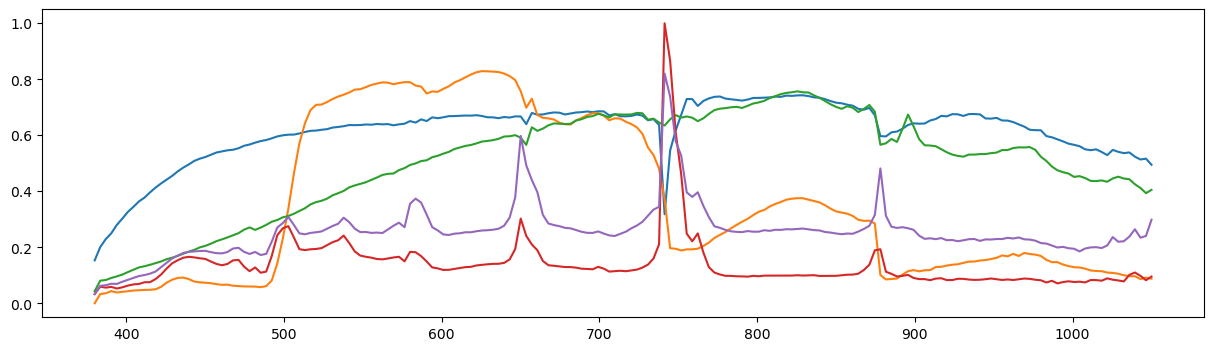

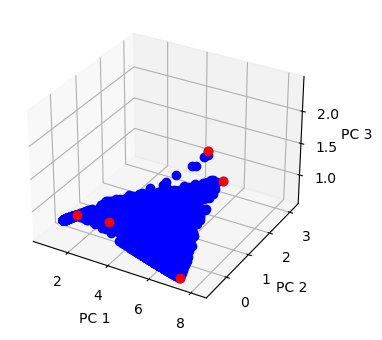

In [55]:
# TO DO
import numpy as np
import scipy.stats
import scipy.io as sio
import matplotlib.pyplot as plt
from pca_viz import pca_viz

## this code snippet generates 1000 points following a uniform distribution on the unit simplex with 3 vertices

alpha = [1,1,1,1]
A_synth_true = scipy.stats.dirichlet.rvs(alpha, size=1000).T

# this part loads some pure spectra taken from real data (vegetation/metallic sheets/asphalt/concrete)

#endmembers = sio.loadmat("endmembers_houston.mat")
data = sio.loadmat("moffett1.mat")

L = 192
wavelengths = np.linspace(380,1050,L) # L is the nomber of bands
# S = endmembers['S0'][:,0:4]\

P=5
endmembers,endmember_coordinates = SPA(im_reshaped,P)
A_synth2 = FCLSU(im_reshaped,endmembers)

S = endmembers

#S= im_reshaped

plt.figure()
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(wavelengths, S)

synth_data = np.dot(S,A_synth2) # X = SA

plt.rcParams["figure.figsize"] = (10,4)
pca_viz(synth_data,S) # this function is used to represent the data in a 3D space 
#(even though they actually live in an L-dimensional space)

In [66]:
print(endmember_coordinates)
e=np.unravel_index(endmember_coordinates,(199,199))
print(e)

[11609, 35290, 27740, 29339, 29338]
(array([ 58, 177, 139, 147, 147], dtype=int64), array([67, 67, 79, 86, 85], dtype=int64))


In [67]:
print(A_synth2.shape)

(5, 39601)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


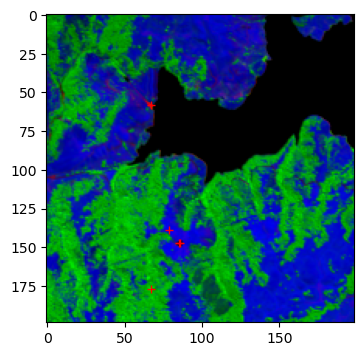

In [68]:
# Abundances

# reshaping the array to an image format.
A_synth2_re=A_synth2.T.reshape(199,199,5)

# plotting points
plt.plot(e[1],e[0],'r+')
#Showing image
plt.imshow(A_synth2_re[:,:,0:3])

### Red plus signs shows exact position of the pure pixels for landcover types.

In the picture the red cross for water seems to be appearing somewhere in the land. However, through visualization of high resolution google imagery, it became evident that there exists a water body within the land. 

(512, 614, 3)


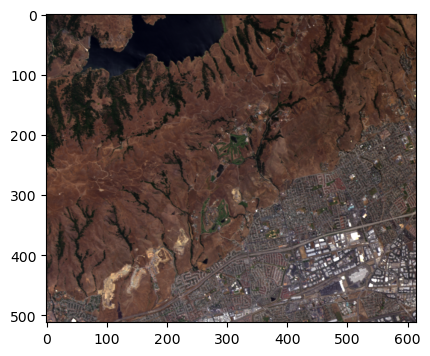

In [69]:
data = sio.loadmat("moffett1.mat")
im = data['im'].astype("double")
imrgb = data['imrgb']

print(imrgb.shape)

plt.imshow(imrgb[:,:,0:3] )

In [165]:
# band ratioing
a=imrgb[:,:,0:1]
b=imrgb[:,:,1:2]
z=(a-b/a+b)

C:\Users\saada\AppData\Local\Temp\ipykernel_10396\2333638572.py:3: RuntimeWarning: divide by zero encountered in divide
  z=(a-b/a+b)


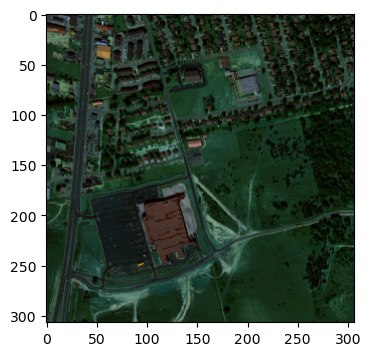

In [72]:
import scipy.io as scio
import pylab as pl
import numpy as np

image = scio.loadmat(r'C:\Users\saada\Desktop\Drive\UBS\Week1\LinearAlgebra\Urban_R162 (2).mat')
nRow = int(image['nRow'])
nCol = int(image['nCol']) 
nBand = 162
Y = np.array(image['Y'],dtype=float)
Y=Y.reshape((nBand,nRow,nCol))/image['maxValue']

Y=np.swapaxes(Y,0,1)
Y=np.swapaxes(Y,1,2)

pl.figure()
pl.imshow(Y[:,:,[50,100,150]])
pl.show()

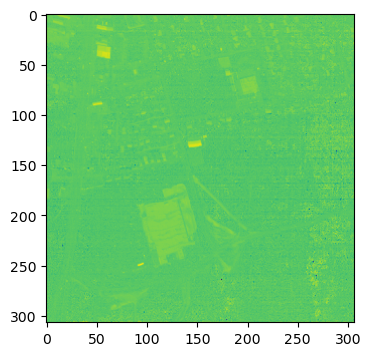

In [73]:
#Displaying ratio image
#a=Y[:,:,0:1]
a=Y[:,:,2:3]
b=Y[:,:,3:4]
z=(a-b/a+b)

plt.imshow(z)

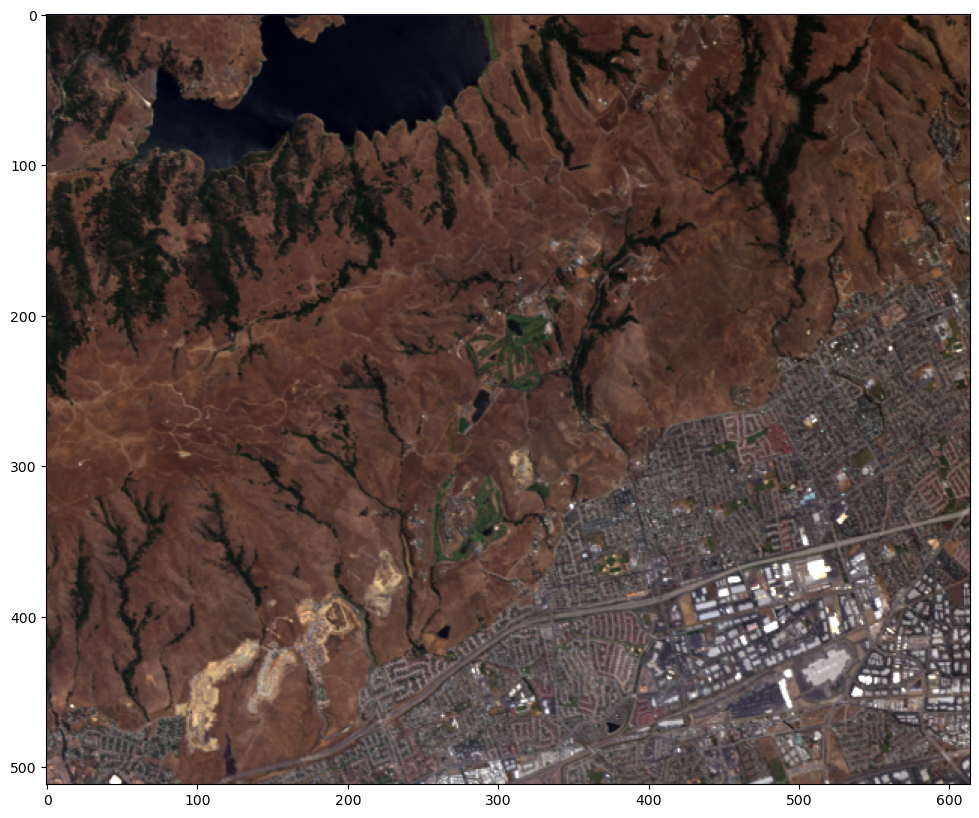

In [157]:
plt.figure(figsize=(20,10))
plt.imshow(imrgb[:,:,:])

In [173]:
from pca_viz import pca_viz
# %matplotlib notebook
from mpl_toolkits.mplot3d import axes3d  
#pca_viz(np.reshape(data['im'],(512*614,204)),endmembers) ## represents the dataset and extracted endmembers in a 3 dimensional space

print(endmembers.shape)
print(data['im'].shape)

(192, 4)
(512, 614, 204)


iteration  0  of  1000 , rel_phi = 0.7526802850483141
iteration  1  of  1000 , rel_phi = 0.1600990634406164
iteration  2  of  1000 , rel_phi = 0.13841627471025536
iteration  3  of  1000 , rel_phi = 0.09639986104646149
iteration  4  of  1000 , rel_phi = 0.04768392391769391
iteration  5  of  1000 , rel_phi = 0.008066628075880034
iteration  6  of  1000 , rel_phi = 0.007596746750993896
iteration  7  of  1000 , rel_phi = 0.00724165737085212
iteration  8  of  1000 , rel_phi = 0.013935245628021418
iteration  9  of  1000 , rel_phi = 0.014997947846230984
iteration  10  of  1000 , rel_phi = 0.017978632583338868
iteration  11  of  1000 , rel_phi = 0.00784117022361342
iteration  12  of  1000 , rel_phi = 0.006384804235636864
iteration  13  of  1000 , rel_phi = 0.003994840057259422
iteration  14  of  1000 , rel_phi = 0.009865264992796467
iteration  15  of  1000 , rel_phi = 0.009843688180903549
iteration  16  of  1000 , rel_phi = 0.011361033993849698
iteration  17  of  1000 , rel_phi = 0.008311407666

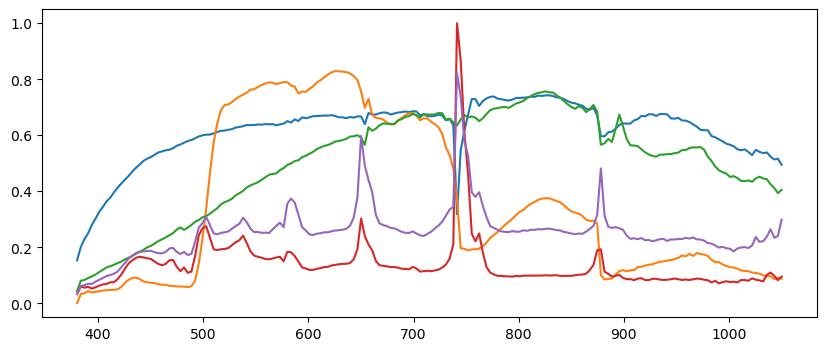

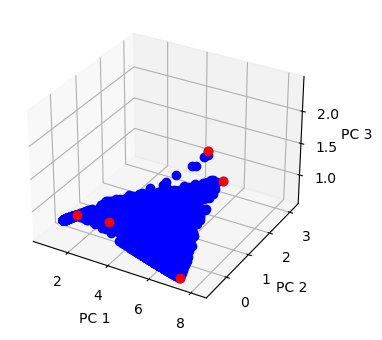

In [175]:
# TO DO
import numpy as np
import scipy.stats
import scipy.io as sio
import matplotlib.pyplot as plt
from pca_viz import pca_viz

## this code snippet generates 1000 points following a uniform distribution on the unit simplex with 3 vertices

alpha = [1,1,1,1]
A_synth_true = scipy.stats.dirichlet.rvs(alpha, size=1000).T

# this part loads some pure spectra taken from real data (vegetation/metallic sheets/asphalt/concrete)

#endmembers = sio.loadmat("endmembers_houston.mat")
data = sio.loadmat("moffett1.mat")

L = 192
wavelengths = np.linspace(380,1050,L) # L is the nomber of bands
# S = endmembers['S0'][:,0:4]\

P=5
endmembers,endmember_coordinates = SPA(im_reshaped,P)
A_synth2 = FCLSU(im_reshaped,endmembers)

S = endmembers

#S= im_reshaped

plt.figure()
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(wavelengths, S)

synth_data = np.dot(S,A_synth2) # X = SA

plt.rcParams["figure.figsize"] = (10,4)
pca_viz(synth_data,S) # this function is used to represent the data in a 3D space 
#(even though they actually live in an L-dimensional space)

Try different values for P until you are satified with the results. Then compute the abundances using the same function as before, and display them as images, together with the corresponding endmembers. Compare the results with the RGB image, and with the high res image from Google Maps

Perform the same unmixing procedure using more endmembers. Are all the endmembers relevant? 

- Trying different values of P, In the following example P = 2 is used as experiment.

Tried unmixing procedure with different number of endmembers. Importantly, results shows that at least 4 of the 5 endmembers are relevant if not all 5.

iteration  0  of  1000 , rel_phi = 0.6912384095203967
iteration  1  of  1000 , rel_phi = 0.1011151657192751
iteration  2  of  1000 , rel_phi = 0.11839307310150446
iteration  3  of  1000 , rel_phi = 0.09079267699372352
iteration  4  of  1000 , rel_phi = 0.030991889623516337
iteration  5  of  1000 , rel_phi = 0.0020895133192337257
iteration  6  of  1000 , rel_phi = 0.01351103964057551
iteration  7  of  1000 , rel_phi = 0.008990021944836862
iteration  8  of  1000 , rel_phi = 0.007439787896601071
iteration  9  of  1000 , rel_phi = 0.016714547128604335
iteration  10  of  1000 , rel_phi = 0.01274134818925406
iteration  11  of  1000 , rel_phi = 0.006636541699864456
iteration  12  of  1000 , rel_phi = 0.0004734499961577717
iteration  13  of  1000 , rel_phi = 0.001084753584811616
iteration  14  of  1000 , rel_phi = 0.007190556164340067
iteration  15  of  1000 , rel_phi = 0.01051559290495521
iteration  16  of  1000 , rel_phi = 0.008976788553014646
iteration  17  of  1000 , rel_phi = 0.0070693296

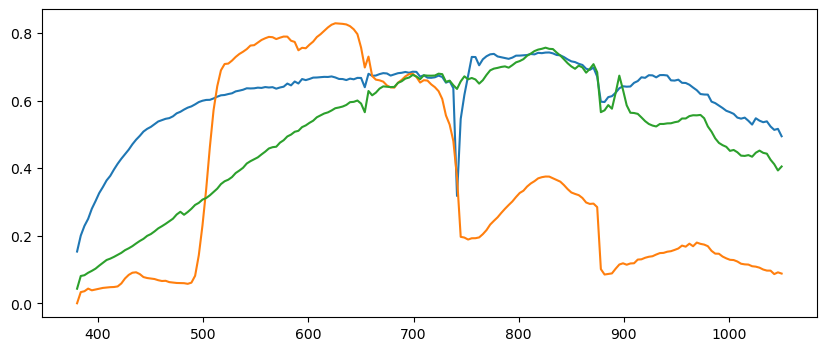

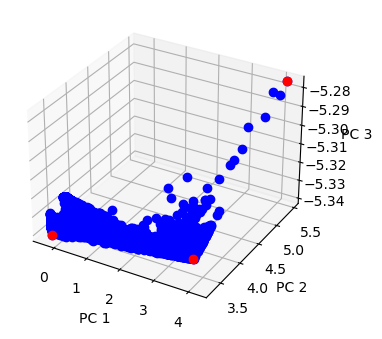

In [167]:
# TO DO
import numpy as np
import scipy.stats
import scipy.io as sio
import matplotlib.pyplot as plt
from pca_viz import pca_viz

## this code snippet generates 1000 points following a uniform distribution on the unit simplex with 3 vertices

alpha = [1,1,1,1]
A_synth_true = scipy.stats.dirichlet.rvs(alpha, size=1000).T

# this part loads some pure spectra taken from real data (vegetation/metallic sheets/asphalt/concrete)

#endmembers = sio.loadmat("endmembers_houston.mat")
data = sio.loadmat("moffett1.mat")

L = 192
wavelengths = np.linspace(380,1050,L) # L is the nomber of bands
# S = endmembers['S0'][:,0:4]\

P=3
endmembers,endmember_coordinates = SPA(im_reshaped,P)
A_synth2 = FCLSU(im_reshaped,endmembers)

S = endmembers

#S= im_reshaped

plt.figure()
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(wavelengths, S)

synth_data = np.dot(S,A_synth2) # X = SA

plt.rcParams["figure.figsize"] = (10,4)
pca_viz(synth_data,S) # this function is used to represent the data in a 3D space 
#(even though they actually live in an L-dimensional space)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11609, 35290, 27740]
(array([ 58, 177, 139], dtype=int64), array([67, 67, 79], dtype=int64))


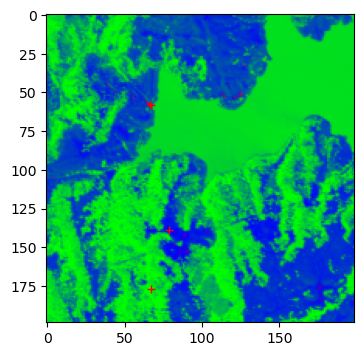

In [168]:
# Compute the abundances
print(endmember_coordinates)
e=np.unravel_index(endmember_coordinates,(199,199))
print(e)

# Abundances

# reshaping the array to an image format.
A_synth2_re=A_synth2.T.reshape(199,199,P)

# Display results
# plotting points
plt.plot(e[1],e[0],'r+')
#Showing image
plt.imshow(A_synth2_re[:,:,0:P])

To finish, we are going to use a variant of the abundance estimation algorithm which adds a sparsity-promoting regularization. Run it on the different configurations you identified before and compare the abundance maps.
Finally, if you have time, try to unmix other areas of the whole image by changing the coordinates of the image in the first cell.

(199, 199, 192)
1.0
0.0
(192, 39601)
iteration  0  of  200 , rel_A = 0.636665793417415
iteration  1  of  200 , rel_A = 0.737869567073972
iteration  2  of  200 , rel_A = 0.7323932883121717
iteration  3  of  200 , rel_A = 0.7098175006091606
iteration  4  of  200 , rel_A = 0.6837784667943058
iteration  5  of  200 , rel_A = 0.6618722329335232
iteration  6  of  200 , rel_A = 0.6482747511238421
iteration  7  of  200 , rel_A = 0.6441179875971748
iteration  8  of  200 , rel_A = 0.6411439790512277
iteration  9  of  200 , rel_A = 0.6368129674098075
iteration  10  of  200 , rel_A = 0.6329205396304355
iteration  11  of  200 , rel_A = 0.6297774067962568
iteration  12  of  200 , rel_A = 0.6273268140111662
iteration  13  of  200 , rel_A = 0.6255387770863627
iteration  14  of  200 , rel_A = 0.6242740071675424
iteration  15  of  200 , rel_A = 0.6233505757884378
iteration  16  of  200 , rel_A = 0.6226687154008533
iteration  17  of  200 , rel_A = 0.6221244636567916
iteration  18  of  200 , rel_A = 0.6216

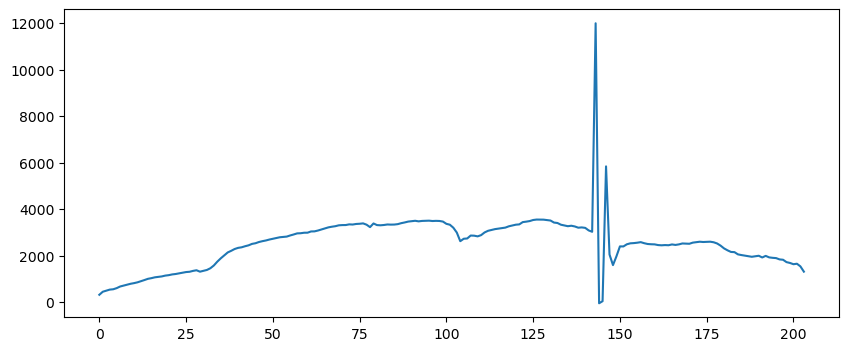

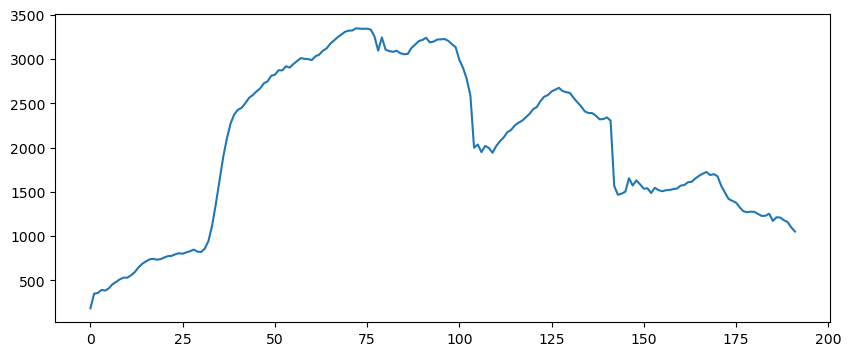

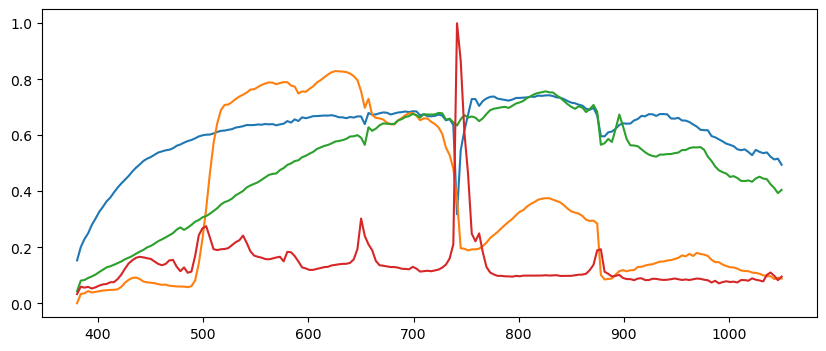

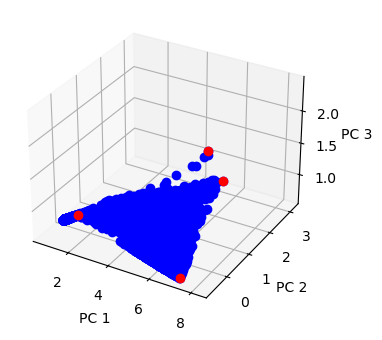

In [170]:
from social_unmixing import social_unmixing

# TO DO
import numpy as np
import scipy.stats
import scipy.io as sio
import matplotlib.pyplot as plt
from pca_viz import pca_viz

# parameters
## this code snippet generates 1000 points following a uniform distribution on the unit simplex with 4 vertices

alpha = [1,1,1,1]
A_synth_true = scipy.stats.dirichlet.rvs(alpha, size=1000).T

# this part loads some pure spectra taken from real data (vegetation/metallic sheets/asphalt/concrete)

#endmembers = sio.loadmat("endmembers_houston.mat")
#data = sio.loadmat("moffett1.mat")
data = sio.loadmat("moffett1.mat")
im = data['im'].astype("double")
imrgb = data['imrgb']

plt.figure()
plt.plot(im[50,50,:]) # plot one pixel

im = np.delete(im,slice(200,224),axis =2) # delete noisy or corrupted bands
im = np.delete(im,slice(142,150),axis =2)
plt.figure()
plt.plot(im[35,24,:]) # plot one pixel after this

im = im[1:200,1:200,:] # select crop on which we will work

im = (im - np.amin(im))/(np.amax(im)-np.amin(im)) # rescale image

print(im.shape)
print(np.amax(im))
print(np.amin(im))

'''
plt.figure(figsize=(20,10))
plt.imshow(imrgb[1:200,1:200,:])
'''
[m,n,L] = im.shape
rgb_small =imrgb[1:200,1:200,:]



im_r=np.reshape(im,(199*199,192)).T
print(im_r.shape)


P=4
endmembers,endmember_coordinates = SPA(im_r,P)

groups = np.arange(0,P)
rho = 10
maxiter_ADMM = 200
algo = "fractional"
fraction = 0.5
tol_a = 10**(-5)
verbose = True

# regularization parameter
Lambda = 0.5 # this values controls the sparsity level. The larger the value, the sparser the solution.
ems =  np.array(endmembers[:,0:P])
A = np.ones([endmembers[:,0:P].shape[1],im_r.shape[1] ])
A_sparse = social_unmixing(im_r,ems,groups,A,Lambda,rho,maxiter_ADMM,algo, fraction,tol_a, verbose)

'''
sources = LxQ endmember matrix, with Q the total number of endmember 
    candidates.
    -groups = Qx1 vector indicating the group structure of the abundance
    matrix. Values have to range between 1 and P, the number of groups 
    (endmembers).
    -A_init: initial QxN abundance matrix: especially useful for the 
'''

L = 192
wavelengths = np.linspace(380,1050,L) # L is the nomber of bands
# S = endmembers['S0'][:,0:4]
S = ems

A_synth2 = FCLSU(im_reshaped,endmembers)

plt.figure()
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(wavelengths, S)

synth_data = np.dot(S,A_synth2) # X = SA

plt.rcParams["figure.figsize"] = (10,4)
pca_viz(synth_data,S) # this function is used to represent the data in a 3D space 
#(even though they actually live in an L-dimensional space)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11609, 35290, 27740, 29339]
(array([ 58, 177, 139, 147], dtype=int64), array([67, 67, 79, 86], dtype=int64))


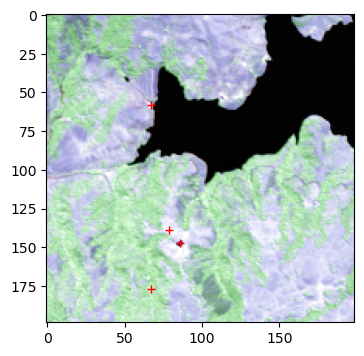

In [171]:
print(endmember_coordinates)
e=np.unravel_index(endmember_coordinates,(199,199))
print(e)

# Abundances

# reshaping the array to an image format.
A_synth2_re=A_synth2.T.reshape(199,199,P)

# plotting points
plt.plot(e[1],e[0],'r+')
#Showing image
plt.imshow(A_synth2_re[:,:,0:P])

Combined data display of abundances and image.